# Anomaly Detection similar to Twitter's Seasonal Hybrid ESD

The basis of this approach is to decompose the signal into a trend, seasonal and residual component, then the Generalised Extreme Stundentized Deviate (ESD) to find up to $n$ anomalies within a given threshold. 

In [1]:
import pandas as pd
import scipy as sp
from scipy.stats import norm

import numpy as np
import statsmodels.api as sm

from PyAstronomy import pyasl

#import matplotlib
import matplotlib.pyplot as plt

#matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
#matplotlib.style.use('ggplot')
plt.style.use('ggplot')

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 2000)

df = pd.read_csv('data/realTraffic/occupancy_t4013.csv', index_col=0, parse_dates=True)
#df = df['2015-04-10':]
df = df['2015-09-10':]

/Users/anindyas/anaconda/envs/tensorflow/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


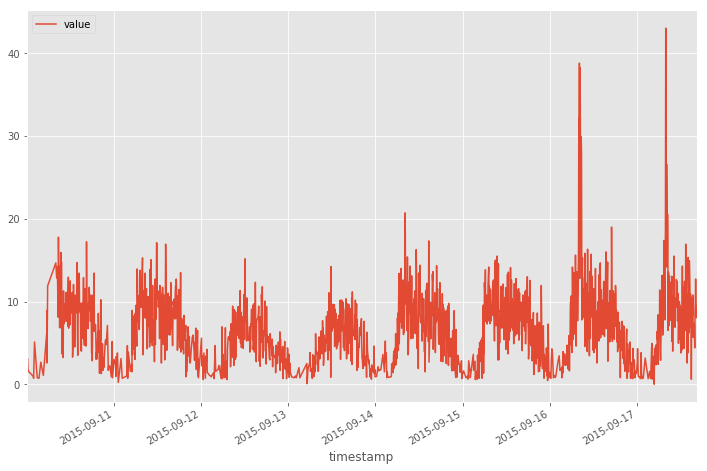

In [2]:
df.plot(figsize=(12, 8));

In [3]:
df.head(5)

,value
timestamp,
2015-09-10 00:03:00,2.61
2015-09-10 00:13:00,3.06
2015-09-10 00:18:00,2.11
2015-09-10 00:23:00,1.61
2015-09-10 01:48:00,0.94


So far so good, we have a noisy signal, with some clear daily periodicity. The records arrive at a rate of roughly 1 every 4-10 minutes. Occationally a record is missing altogether. Real world data is noisy so we have to handle that.

## Probability distribution of raw signal

In this case a Normal distribution is not too bad, as we will see latter there is not a significant trend in this example which can have the biggest impact on a good fit.  

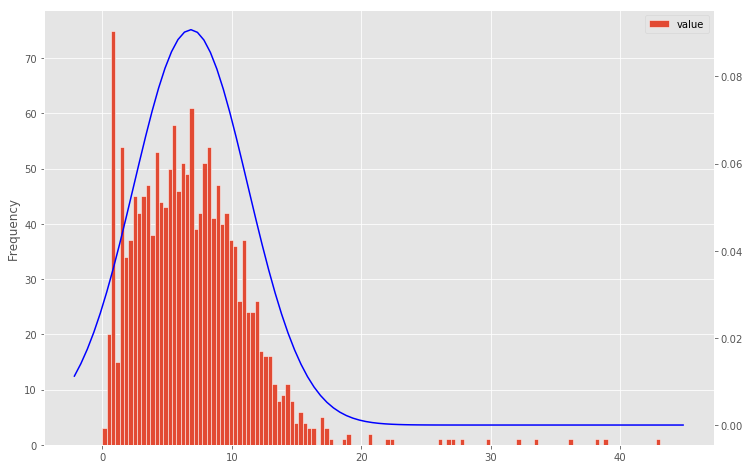

In [4]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax2.grid(False)
df.plot.hist( stacked=True, bins=128, ax=ax1, edgecolor='white')

xmin,xmax,ymin,ymax = plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
plt.plot(x_axis, norm.pdf(x_axis,df.mean(),df.std()), color='blue');

## Seasonal decomposition

This is where the raw signal is plit into it's components, but first we have to handle noisy and missing data, here we:
 - Resample, aggregate the signal into fixed time buckets calculated using the mean
 - Intermolate filling any missing holes based on surronding data

This gives the plot below. It is importaing to choose a correct basis for resampling and looking for seasonality. I've chosen to keep the signal samples pretty close to the original (15min), then use 24hrs worth of samples when looking for seasonality. This keeps the signal close to the original, but maximised the seasonal component.  

*Note:* I believe twitter uses a polynomial fit to extract the trend, the 'statsmodels' method uses moving averages / convolution. Hence the delay before the trend line starts.

In [5]:
s_rule = '15T' #15 mins
n_sample = 96  #Number of 15mins in 24 hours  
sf = df.resample(s_rule).mean()
sf.interpolate(method='time',inplace=True)

In [6]:
sf.head(10)

,value
timestamp,
2015-09-10 00:00:00,2.835000
2015-09-10 00:15:00,1.860000
2015-09-10 00:30:00,1.688333
2015-09-10 00:45:00,1.516667
2015-09-10 01:00:00,1.345000
2015-09-10 01:15:00,1.173333
2015-09-10 01:30:00,1.001667
2015-09-10 01:45:00,0.830000
2015-09-10 02:00:00,5.110000


In [7]:
res = sm.tsa.seasonal_decompose(sf.values, two_sided=False, freq=n_sample)

In [8]:
dates = pd.date_range(start='2015-09-10 00:00:00', freq='15T', periods=len(sf))
rf = pd.DataFrame(data=np.c_[sf.values, res.trend, res.seasonal, res.resid], 
                  columns=['sampled', 'trend', 'seasonal', 'residual'], index=sf.index)

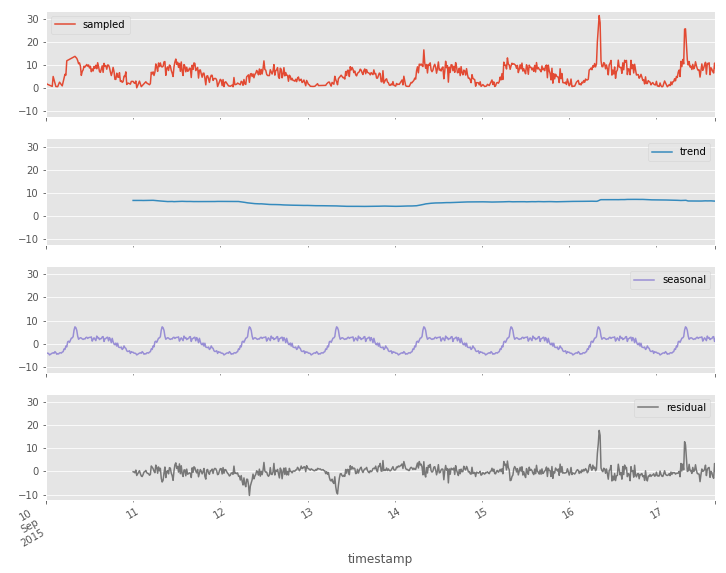

In [9]:
rf.plot(subplots=True, sharey=True, figsize=(12,10));

Not looking at the 'residual' signal probability distribution we see it is a much better fit to a Normal distribution. 

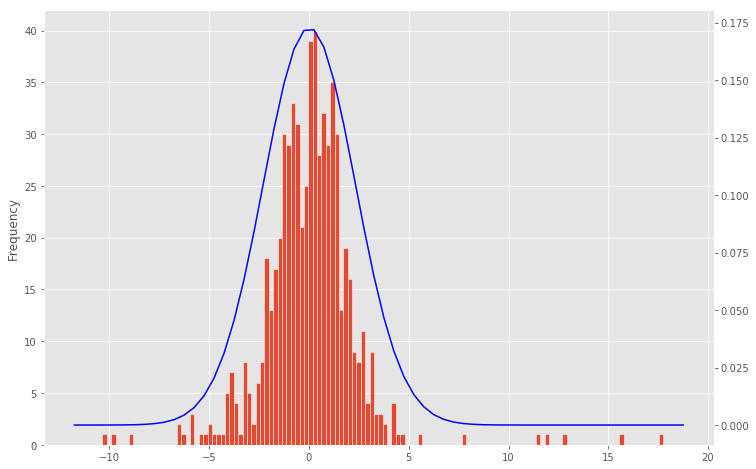

In [10]:
sf = rf.residual
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax2.grid(False)
sf.plot.hist( stacked=True, bins=128, ax=ax1, edgecolor='white' )

xmin, xmax, ymin, ymax = plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
plt.plot(x_axis, norm.pdf(x_axis, sf.mean(), sf.std()), color='blue');

With that established we can start looking for anomalies. This is done with Generalised ESD. Anomalies are marked in the diagram below.

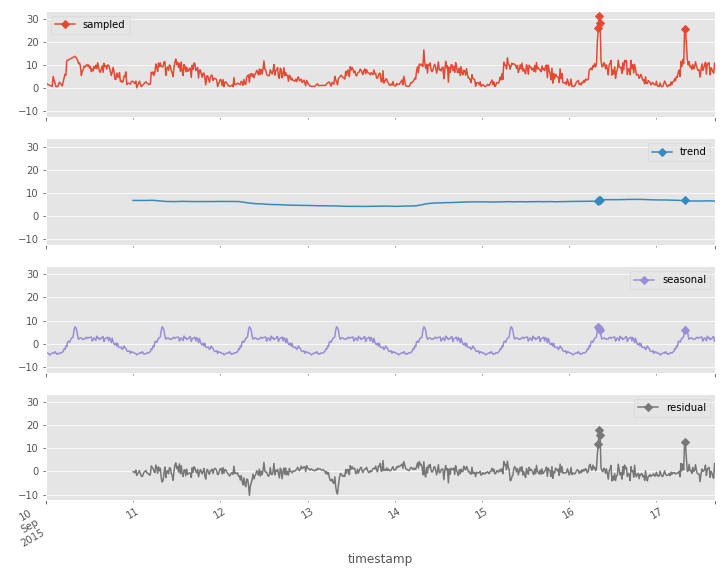

In [11]:
arr = rf['residual'][n_sample:]
nos, anomalies = pyasl.generalizedESD(x=arr, maxOLs=4, alpha=0.05, fullOutput=False)
mark = [x+n_sample for x in anomalies]
ax = rf.plot(subplots=True, sharey=True, marker='D', markevery=mark, figsize=(12,10));

In [12]:
mark.sort()
print(nos, mark)
rf.iloc[mark]

4 [608, 609, 610, 703]


,sampled,trend,seasonal,residual
timestamp,,,,
2015-09-16 08:00:00,25.870000,6.575512,7.330492,11.963996
2015-09-16 08:15:00,31.426667,6.766771,6.916500,17.743396
2015-09-16 08:30:00,28.313333,6.967292,5.774406,15.571636
2015-09-17 07:45:00,25.540000,6.783038,5.903473,12.853489
